# Import Libraries

In [1]:
import librosa
# import tensorflow as tf
import scipy.io.wavfile as wav
import librosa.display
import matplotlib.pyplot as plt
import pyaudio
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# from keras import backend as K
from pydub import AudioSegment
from pydub.playback import play
import glob
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D, BatchNormalization,LSTM
import sounddevice as sd
from keras.models import Sequential,load_model
import librosa.util
import numpy as np
import pandas as pd
import random
import soundfile as sf
from ann_visualizer.visualize import ann_viz
from sklearn.model_selection import train_test_split
%matplotlib inline
np.random.seed(2)
output_res = ['Alarm','Noise']

Using TensorFlow backend.


In [2]:
# y, sr = librosa.load('n3.wav', duration=4)
# print(y.shape)
# ps = librosa.feature.melspectrogram(y=y, sr=22050)
# librosa.display.specshow(ps, y_axis='mel', x_axis='time')
# ps = librosa.feature.melspectrogram(y=y, sr=sr)
# ps.shape

# Data_Preprocessing
This involves loading the audio data to cache.
This may take some minutes

In [9]:
D_cache = []
count = 0
for i in glob.iglob('*.wav'):
    y,sr = librosa.load(i, duration=2.97)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    D_cache.append(ps)
    count+=1

print('Datasets_available:',count)

Datasets_available: 756


Reshaping the data such that it fits to the input of Convolutional Neural Network

In [10]:
data_set = []
scaler = StandardScaler()
for data in D_cache:
    data = scaler.fit_transform(data).reshape(128,128,1)
    data_set.append(data)
    
data_set = np.asarray(data_set)

print(data_set.shape)

(756, 128, 128, 1)


In [11]:
data_set = np.array([x.reshape( (128, 128, 1) ) for x in data_set])
data_set.shape

(756, 128, 128, 1)

Here the datasets or samples are labeled with its name.
Samples that start with 'd' are Beep sounds and those starting with 'n' are environmental sounds
When the sample name starts with 'd', the network is forced to fit with output (1,0) and when it is 'n' then the label is (0,1)

In [12]:
labels = []
for file in glob.iglob('*.wav'):
    if(file[0]=='n'):
        labels.append([0,1])
    elif(file[0]=='d'):
        labels.append([1,0])
labels = np.asarray(labels)
len(labels)

756

# Test_Train_Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    data_set, labels, test_size=0.33,random_state = 42)

In [20]:
# #To see output in each layer
# outputs = [layer.output for layer in model.layers]

This is the proposed CNN model for predicting the Beep Alarm sounds. This may need some changes such as adding a network layer, increasing the number of nodes in a layer, optimising method, etc based on the use case.

In [14]:
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(4, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 4)))
model.add(Activation('relu'))

model.add(Conv2D(1, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 4)))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(6))
# model.add(Activation('sigmoid'))
model.add(Activation('relu'))

# model.add(Dense(4))
# model.add(Activation('relu'))
# model.add(Activation('sigmoid'))

model.add(Dense(2))
model.add(Activation('sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 4)       104       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 4)         0         
_________________________________________________________________
activation_1 (Activation)    (None, 31, 31, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 1)         101       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 1)           0         
_________________________________________________________________
activation_2 (Activation)    (None, 6, 6, 1)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36)                0         
__________

To visualize the model use this function. This is Cool :D

In [17]:
# # model = []
ann_viz(model)

## Here comes the main part, Training the model and testing to analyse the Accuracy.
Note: In case of unbalanced data we need F1 score as well.

Train on 506 samples, validate on 250 samples
Epoch 1/15
506/506 [==============================] - 10s 20ms/step - loss: 0.4875 - acc: 0.7312 - val_loss: 0.3584 - val_acc: 0.7900
Epoch 2/15
506/506 [==============================] - 7s 15ms/step - loss: 0.4098 - acc: 0.7668 - val_loss: 0.3170 - val_acc: 0.8180
Epoch 3/15
506/506 [==============================] - 8s 15ms/step - loss: 0.3650 - acc: 0.7875 - val_loss: 0.2919 - val_acc: 0.8300
Epoch 4/15
506/506 [==============================] - 8s 16ms/step - loss: 0.3354 - acc: 0.8123 - val_loss: 0.2706 - val_acc: 0.8480
Epoch 5/15
506/506 [==============================] - 8s 15ms/step - loss: 0.3100 - acc: 0.8409 - val_loss: 0.2531 - val_acc: 0.8860
Epoch 6/15
506/506 [==============================] - 7s 14ms/step - loss: 0.2884 - acc: 0.8656 - val_loss: 0.2368 - val_acc: 0.9160
Epoch 7/15
506/506 [==============================] - 8s 15ms/step - loss: 0.2697 - acc: 0.8943 - val_loss: 0.2223 - val_acc: 0.9440
Epoch 8/15
506/506 [==

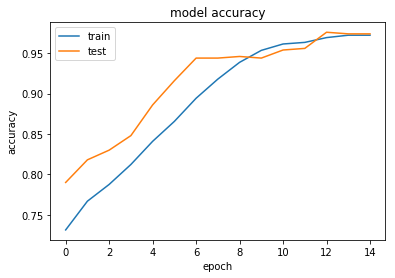

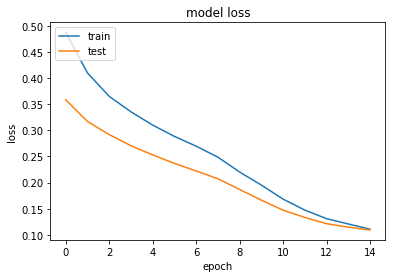

Test loss: 0.109594209075
Test accuracy: 0.974


In [18]:
model.compile(
            optimizer="Adam",
            loss="binary_crossentropy",
            metrics=['accuracy'])

history = model.fit(
        x=X_train, 
        y=y_train,
        epochs=15,
        batch_size=15,
        validation_data= (X_test, y_test))

score = model.evaluate(
        x=X_test,
        y=y_test)

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

The model's Accuracy is 97%. Hurray!!

In [19]:
model.save('cnn_model.h5')
# model = load_model('my_model.h5')
# model.save_weights('my_model_weights.h5')
# model.load_weights('my_model_weights.h5')
# model.predict(np.array([a[0],]))

In [21]:
# from sklearn.metrics import f1_score
# f1_score(, y_pred, average='macro') 

# Testing
This involves realtime recording using Microphone for 3.97 seconds and using the audio as input to the proposed model. In highly noisy environments model may fail to predict the Beep sounds. In such cases Peak detection is used with the prediction score of the Neural Network.

In [29]:
%%time
RATE = 22050
RECORD_SECONDS = 3.97
CHUNKSIZE = 1024
my_model = load_model('cnn_model.h5')
p = pyaudio.PyAudio()

#Loop
timeesz = 0
while True:
    stream = p.open(format=pyaudio.paFloat32, channels=1, rate=RATE, input=True, frames_per_buffer=CHUNKSIZE)

    frames = [] # A python-list of chunks(numpy.ndarray)

    for _ in range(0, int(RATE / CHUNKSIZE * RECORD_SECONDS)):
        data = stream.read(CHUNKSIZE)
        frames.append(np.fromstring(data, dtype=np.float32))

    #Convert the list of numpy-arrays into a 1D array (column-wise)
    numpydata = np.hstack(frames)

    # close stream
    stream.stop_stream()
    wav.write('p'+str(1000)+'.wav',RATE,numpydata)
    
    y,sr = librosa.load('p'+str(1000)+'.wav', duration=2.97)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    ps = ps.reshape(128,128,1)
    predictions = my_model.predict(np.array([ps,]))
    print("Predictions:",predictions)
    confidence = predictions[0][0]*100
    print(confidence)
    if(confidence>=85):
#         print('Beep Sounds')
        timeesz +=1
        onset_env = librosa.onset.onset_strength(y=y, sr=22050,
                                                         hop_length=512,
                                                         aggregate=np.median)
        peaks = librosa.util.peak_pick(onset_env, 3, 3, 3, 5, 0.5, 35)
        times = librosa.frames_to_time(np.arange(len(onset_env)),
                                   sr=sr, hop_length=512)
        if(len(peaks)==0 or len(peaks)==1):
            print('\nAbnormal as number of peaks detected is ',format(len(peaks)))
        else:
            val = times[peaks]
            if(val[1]-val[0]<=1 or len(peaks)>=4):
                print('Alarm Sound')
                time.sleep(0.6)
            else:
                print('Normal Beeps')
    else:
        print('Noise')
    if(timeesz==10):
        break
        
stream.close()
p.terminate()

Predictions: [[ 0.41772324  0.56015396]]
41.7723238468
Noise
Predictions: [[ 0.41741404  0.55343485]]
41.7414039373
Noise
Predictions: [[ 0.9835543   0.04046832]]
98.3554303646
Normal Beeps
Predictions: [[ 0.99438089  0.02363318]]
99.4380891323
Normal Beeps
Predictions: [[  1.00000000e+00   4.29974556e-10]]
100.0
Normal Beeps
Predictions: [[  1.00000000e+00   1.92025141e-06]]
100.0
Alarm Sound
Predictions: [[ 0.78244925  0.11016072]]
78.2449245453
Noise
Predictions: [[ 0.46358645  0.50279504]]
46.3586449623
Noise
Predictions: [[ 0.41772324  0.56015396]]
41.7723238468
Noise
Predictions: [[ 0.41772324  0.56015396]]
41.7723238468
Noise
Predictions: [[ 0.83844554  0.10803385]]
83.8445544243
Noise
Predictions: [[  9.99996901e-01   7.47957586e-07]]
99.9996900558
Alarm Sound


KeyboardInterrupt: 

In [109]:
# ps = ps.reshape(128,128,1)
# predictions = model.predict(np.array([ps,]))
# print("Predictions:",predictions,'\n',
#      output_res[np.argmax(predictions)])

# Data Augmentation
This is the role playing part. As the model's accuracy was very less close to 82%. Each sample is augmented using three techniques namely time stretching, pitch shifting. Therefore the resulting number of Samples is 756 and this increases the Accuracy of the Model.

In [112]:
rate = 0.81 # replace with 0.81 and execute again
count = 137
for row in glob.iglob('*.wav'):
    count+=1
    y, sr = librosa.load(row)
    y_changed = librosa.effects.time_stretch(y, rate=rate)
    if(row[0]=='d'):
        librosa.output.write_wav('d_changed'+str(count)+'.wav' ,y_changed, sr)
#         print("d")
    elif(row[0]=='n'):
        librosa.output.write_wav('n_changed'+str(count)+'.wav' ,y_changed, sr)
#         print("n")
#     if(count==140):
    break

In [166]:
count = 1

file_names = glob.glob('*.wav')
data = []

for file in file_names:
    if(file[0]=='d'):
        parent_data,sr = librosa.load(file,sr=22050,duration=4)
#         print(parent_data.shape)
        #Adding Noise
        wn = np.random.randn(len(parent_data))
        data_wn = parent_data + 0.005*wn
        #Stretching with time
        data_time = librosa.effects.time_stretch(y=parent_data, rate=0.81)
        wav.write('dstretch'+str(count)+'.wav',rate=22100, data=data_time)
        #Pitch_shift
        pitch_shift_data = librosa.effects.pitch_shift(parent_data, sr=22050, n_steps=2)
        wav.write('dpitch'+str(count)+'.wav',rate=22100, data=pitch_shift_data)
        #Roll
        data_roll = np.roll(parent_data, 1600)
        wav.write('droll'+str(count)+'.wav',rate=22100, data=data_roll)
        count+=1
    elif(file[0]=='n'):
        parent_data,sr = librosa.load(file,sr=22050,duration=4)
#         print(parent_data.shape)
        #Adding Noise
        wn = np.random.randn(len(parent_data))
        data_wn = parent_data + 0.005*wn
        #Stretching with time
        data_time = librosa.effects.time_stretch(y=parent_data, rate=0.81)
        wav.write('nstretch'+str(count)+'.wav',rate=22100, data=data_time)
        #Pitch_shift
        pitch_shift_data = librosa.effects.pitch_shift(parent_data, sr=22050, n_steps=2)
        wav.write('npitch'+str(count)+'.wav',rate=22100, data=pitch_shift_data)
        #Roll
        data_roll = np.roll(parent_data, 1600)
        wav.write('nroll'+str(count)+'.wav',rate=22100, data=data_roll)
        count+=1
    

In [78]:
np.amax(x_train)

11.100129644003733